In [1]:
from openvino.inference_engine import IENetwork, IEPlugin
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
aa = np.random.randn(100).reshape(1,-1)
bb = np.random.randn(100).reshape(1,-1)
cc = np.array([40,54,690]).reshape(1,-1)

cosine_similarity(aa, bb)[0][0]

-0.07200863081217573

In [3]:
plugin = IEPlugin(device="CPU")
plugin.add_cpu_extension(r"C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\inference_engine\bin\intel64\Release\cpu_extension_avx2.dll")

model_xml = "models/person-detection-retail-0013.xml"
model_bin = "models/person-detection-retail-0013.bin"

In [4]:
def load_model(plugin, model, weights):
    """
    Load OpenVino IR Models

    Input:
    Plugin = Hardware Accelerator
    Model = model_xml file 
    Weights = model_bin file
    
    Output:
    execution network (exec_net)
    """
    #  Read in Graph file (IR) to create network
    net = IENetwork(model, weights) 
    # Load the Network using Plugin Device
    exec_net = plugin.load(network=net)
    return net, exec_net

def preprocessing(n, c, h, w, image):
    """
    Image Preprocessing steps, to match image 
    with Input Neural nets
    
    N=1, Channel=3, Height=62, Width=62
    """
    blob = cv.resize(image, (w, h)) # Resize width & height
    blob = blob.transpose((2, 0, 1)) # Change data layout from HWC to CHW
    blob = blob.reshape((n, c, h, w))
    return blob

## Person Detection

In [5]:
net, exec_net = load_model(plugin, model_xml,model_bin)

input_net = 'data'
output_net = 'detection_out'

n,c,h,w = net.inputs[input_net].shape

In [6]:
net.outputs['detection_out'].shape

[1, 1, 200, 7]

(902, 1601, 3)


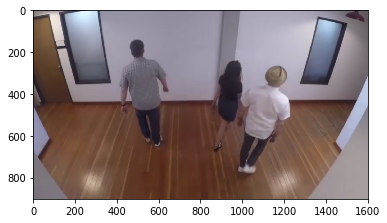

In [7]:
image_1 = cv.imread('test_image1.png')
img_1 = image_1.copy()
plt.imshow(image_1[...,::-1]);
print(image_1.shape)

In [8]:
blob = preprocessing(n,c,h,w, image_1)
req_handle = exec_net.start_async(0, {input_net:blob})

In [9]:
status = req_handle.wait()
res = req_handle.outputs[output_net]
res.shape

(1, 1, 200, 7)

In [10]:
res[0][0][0:3]

array([[0.        , 1.        , 0.998926  , 0.59963655, 0.3004798 ,
        0.7743883 , 0.9180858 ],
       [0.        , 1.        , 0.99802905, 0.25844467, 0.1570496 ,
        0.4043159 , 0.94416374],
       [0.        , 1.        , 0.99061686, 0.53394294, 0.2651455 ,
        0.63580334, 0.801031  ]], dtype=float32)

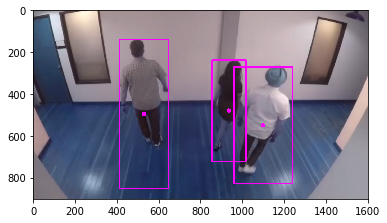

In [11]:
person_db1 = []
for det_id, detection in enumerate(res[0][0]):
    confidence = detection[2]
    xmin = int(detection[3] * image_1.shape[1])
    ymin = int(detection[4] * image_1.shape[0])
    xmax = int(detection[5] * image_1.shape[1])
    ymax = int(detection[6] * image_1.shape[0])
    if confidence > 0.9:
        crop_person = image_1[ymin:ymax, xmin:xmax].copy()
        cv.imwrite('person/{}_person.jpg'.format(str(det_id)),crop_person)
        person_db1.append(crop_person)
        cv.rectangle(img_1, (xmin, ymin), (xmax, ymax), (255,0,255), 5)
        centroid = (int(xmin + ((xmax - xmin)/2)), int(ymin + ((ymax-ymin)/2)))
        cv.circle(img_1, centroid, 5, (255,0,255), 10)
        

plt.imshow(img_1);

### Predict with image 2

(902, 1602, 3)


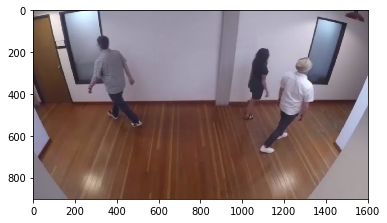

In [12]:
image_2 = cv.imread('test_image2.png')
img_2 = image_2.copy()
plt.imshow(image_2[...,::-1]);
print(image_2.shape)

In [13]:
blob = preprocessing(n,c,h,w, image_2)
req_handle = exec_net.start_async(0, {input_net:blob})

In [14]:
status = req_handle.wait()
res = req_handle.outputs[output_net]
res.shape

(1, 1, 200, 7)

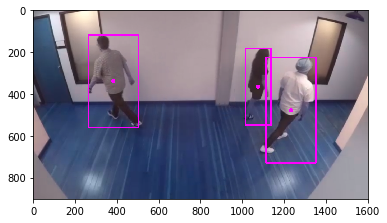

In [15]:
person_db2 = []
for det_id, detection in enumerate(res[0][0]):
    confidence = detection[2]
    xmin = int(detection[3] * image_2.shape[1])
    ymin = int(detection[4] * image_2.shape[0])
    xmax = int(detection[5] * image_2.shape[1])
    ymax = int(detection[6] * image_2.shape[0])
    if confidence > 0.9:
        crop_person = image_2[ymin:ymax, xmin:xmax].copy()
        cv.imwrite('person/{}_person_img2.jpg'.format(str(det_id)),crop_person)
        person_db2.append(crop_person)
        cv.rectangle(img_2, (xmin, ymin), (xmax, ymax), (255,0,255), 5)
        centroid = (int(xmin + ((xmax - xmin)/2)), int(ymin + ((ymax-ymin)/2)))
        cv.circle(img_2, centroid, 5, (255,0,255), 10)
        

plt.imshow(img_2);

### Compare Result

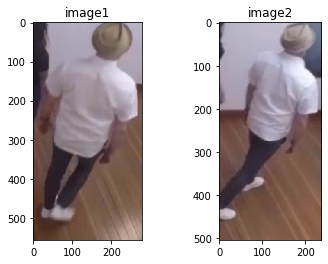

In [16]:
plt.subplot(121);plt.imshow(person_db1[0][...,::-1]);plt.title('image1');
plt.subplot(122);plt.imshow(person_db2[0][...,::-1]);plt.title('image2');

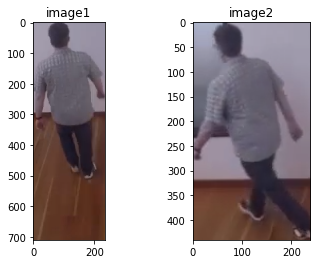

In [17]:
plt.subplot(121);plt.imshow(person_db1[1][...,::-1]);plt.title('image1');
plt.subplot(122);plt.imshow(person_db2[1][...,::-1]);plt.title('image2');

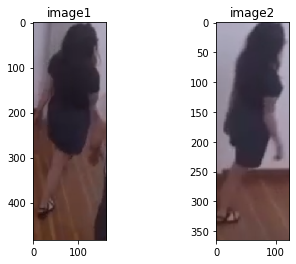

In [18]:
plt.subplot(121);plt.imshow(person_db1[2][...,::-1]);plt.title('image1');
plt.subplot(122);plt.imshow(person_db2[2][...,::-1]);plt.title('image2');

___

## Reidentification

In [19]:
reid_xml = "models/person-reidentification-retail-0031.xml"
reid_bin = "models/person-reidentification-retail-0031.bin"

reid_net, reid_exec_net = load_model(plugin, reid_xml, reid_bin)

In [20]:
input_net = 'data'
output_net = 'ip_reid'

n,c,h,w = reid_net.inputs[input_net].shape
print(n, c, h, w)

1 3 96 48


### Compare Person from Person detection

In [21]:
# From Image 1
person_a1 = person_db1[0]
person_b1 = person_db1[1]
person_c1 = person_db1[2]
# From Image  2
person_a2 = person_db2[0]
person_b2 = person_db2[1]
person_c2 = person_db2[2]

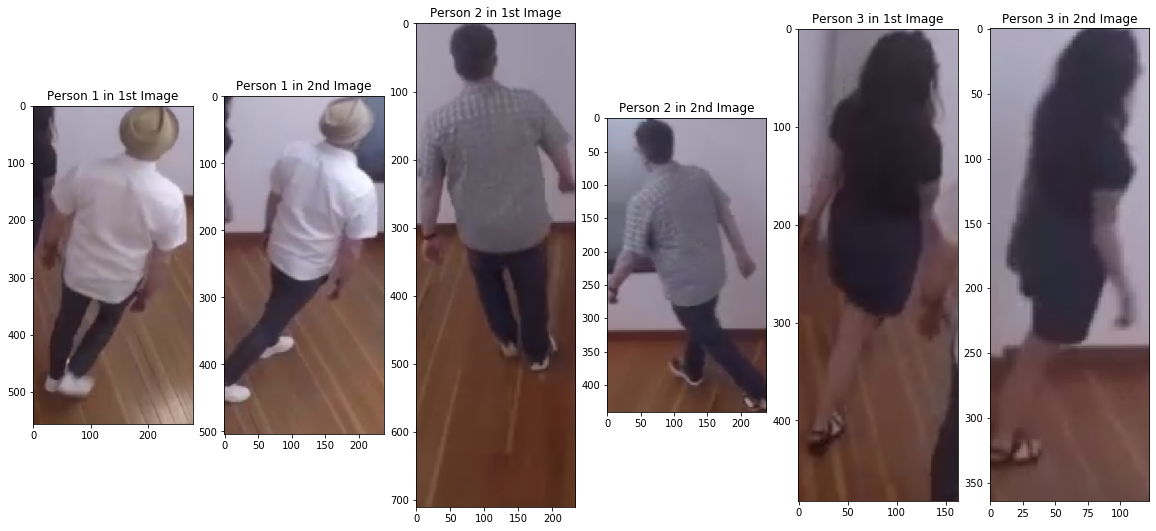

In [22]:
plt.figure(figsize=[20,20])
plt.subplot(161);plt.imshow(person_a1[...,::-1]);plt.title('Person 1 in 1st Image');
plt.subplot(162);plt.imshow(person_a2[...,::-1]);plt.title('Person 1 in 2nd Image');
plt.subplot(163);plt.imshow(person_b1[...,::-1]);plt.title('Person 2 in 1st Image');
plt.subplot(164);plt.imshow(person_b2[...,::-1]);plt.title('Person 2 in 2nd Image');
plt.subplot(165);plt.imshow(person_c1[...,::-1]);plt.title('Person 3 in 1st Image');
plt.subplot(166);plt.imshow(person_c2[...,::-1]);plt.title('Person 3 in 2nd Image');

# Inference Based on Detection

### Person A in image 1

In [23]:
blob = preprocessing(n,c,h,w, person_a1)
req_handle = reid_exec_net.start_async(0, {input_net:blob})

In [24]:
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [25]:
id_person_a1 = res

### Person B in image 1

In [26]:
blob = preprocessing(n,c,h,w, person_b1)
req_handle = reid_exec_net.start_async(0, {input_net:blob})

In [27]:
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [28]:
id_person_b1 = res

### Person C in image 1

In [29]:
blob = preprocessing(n,c,h,w, person_c1)
req_handle = reid_exec_net.start_async(0, {input_net:blob})

In [30]:
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [31]:
id_person_c1 = res

## Image 2

### Person A in image 2

In [32]:
blob = preprocessing(n,c,h,w, person_a2)
req_handle = reid_exec_net.start_async(0, {input_net:blob})

In [33]:
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [34]:
id_person_a2 = res

### Person B in image 2

In [35]:
blob = preprocessing(n,c,h,w, person_b2)
req_handle = reid_exec_net.start_async(0, {input_net:blob})

In [36]:
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [37]:
id_person_b2 = res

### Person C in image 2

In [38]:
blob = preprocessing(n,c,h,w, person_c2)
req_handle = reid_exec_net.start_async(0, {input_net:blob})

In [39]:
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [40]:
id_person_c2 = res

### Check Similarity

In [41]:
cosine_similarity(id_person_a1, id_person_a2)

array([[0.67241156]], dtype=float32)

In [43]:
cosine_similarity(id_person_a1, id_person_b1)

array([[0.33624488]], dtype=float32)

In [64]:
cosine_similarity(id_person_a1, id_person_b2)[0][0]

0.20487328

## Similarity Table

In [69]:
from pandas import DataFrame
from itertools import permutations
param = {'id_person_a1':id_person_a1,'id_person_b1':id_person_b1,'id_person_c1':id_person_c1,
         'id_person_a2':id_person_a2,'id_person_b2':id_person_b2,'id_person_c2':id_person_c2}
cosim = DataFrame(columns=param.keys(), index=param.keys())
cosim

,id_person_a1,id_person_b1,id_person_c1,id_person_a2,id_person_b2,id_person_c2
id_person_a1,NaN,NaN,NaN,NaN,NaN,NaN
id_person_b1,NaN,NaN,NaN,NaN,NaN,NaN
id_person_c1,NaN,NaN,NaN,NaN,NaN,NaN
id_person_a2,NaN,NaN,NaN,NaN,NaN,NaN
id_person_b2,NaN,NaN,NaN,NaN,NaN,NaN
id_person_c2,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
perm = permutations(param.keys(),2)
for val in perm:
    cosim[val[0]][val[1]]=cosine_similarity(param[val[0]], param[val[1]])[0][0]
    
cosim

,id_person_a1,id_person_b1,id_person_c1,id_person_a2,id_person_b2,id_person_c2
id_person_a1,NaN,0.336245,0.148843,0.672412,0.204873,0.0870442
id_person_b1,0.336245,NaN,0.577367,0.471808,0.655281,0.42239
id_person_c1,0.148843,0.577367,NaN,0.19611,0.515031,0.75963
id_person_a2,0.672412,0.471808,0.19611,NaN,0.458571,0.253582
id_person_b2,0.204873,0.655281,0.515031,0.458571,NaN,0.540716
id_person_c2,0.0870442,0.42239,0.75963,0.253582,0.540716,NaN
